In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
from matplotlib import pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

plt.rcParams['figure.figsize'] = (15, 5)

In [15]:
tickers = ['xle', 'xlu', 'xlb', 'xlk', 'xli', 'xlv', 'xlf', 'xlp', 'xly']
end_date = '2023-08-07'

In [16]:
price_dataframe = yf.download(tickers, end=end_date)['Close']

preprocessed_dataframe = price_dataframe.fillna(method='ffill')
preprocessed_dataframe = preprocessed_dataframe.dropna()

[*********************100%***********************]  9 of 9 completed


In [17]:
normalizedDataframe = preprocessed_dataframe.pct_change().dropna()

In [18]:
lookbacks = np.arange(2, (21*12*1)+1, 1)

In [19]:
def getSignal(dataframe, signal, cross_sectional, long_only):

    if cross_sectional:
        signal = pd.DataFrame(signal).rank(axis=1, ascending=True).values

        means = np.mean(signal, axis=1)
        stds = np.std(signal, axis=1)
        normalized_signal = (signal - means[:, np.newaxis]) / stds[:, np.newaxis]
        signal = normalized_signal

        if long_only:
            signal[signal <= 0] = np.nan
            weights = (~np.isnan(signal)).astype(float)
            weights /= np.nansum(weights, axis=1)[:, np.newaxis]
        else:
            positive_signal = np.where(signal > 0, signal, np.nan)
            positive_weights = pd.DataFrame(positive_signal).rank(axis=1, ascending=True).values
            positive_weights /= np.nansum(positive_weights, axis=1)[:, np.newaxis]

            negative_signal = np.where(signal < 0, signal, np.nan)
            negative_weights = pd.DataFrame(negative_signal).rank(axis=1, ascending=False).values
            negative_weights /= np.nansum(negative_weights, axis=1)[:, np.newaxis]

            weights = np.where(signal > 0, positive_weights, negative_weights)
    else:
        if long_only:
            signal[signal <= 0] = np.nan
            weights = (~np.isnan(signal)).astype(float)
            weights /= np.nansum(weights, axis=1)[:, np.newaxis]

        else:
            positive_signal = np.where(signal > 0, signal, np.nan)
            positive_weights = (~np.isnan(positive_signal)).astype(float)
            positive_weights /= np.nansum(positive_weights, axis=1)[:, np.newaxis]

            negative_signal = np.where(signal < 0, signal, np.nan)
            negative_weights = (~np.isnan(negative_signal)).astype(float)
            negative_weights /= np.nansum(negative_weights, axis=1)[:, np.newaxis]

            weights = np.where(signal > 0, positive_weights, negative_weights)

    signal = np.sign(signal)

    return pd.DataFrame(signal * weights, index=dataframe.index, columns=dataframe.columns)

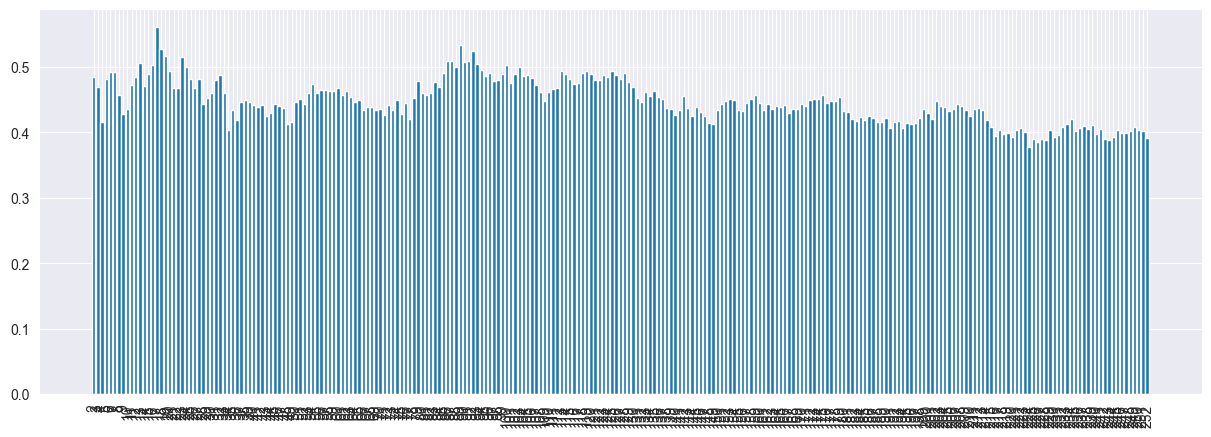

In [44]:
def backtest(dataframe, lookbacks):
    first = dataframe.iloc[:int(len(dataframe)/5)]
    second = dataframe.iloc[int(len(dataframe)/5):int(len(dataframe)/5*2)]
    third = dataframe.iloc[int(len(dataframe)/5*2):int(len(dataframe)/5*3)]
    fourth = dataframe.iloc[int(len(dataframe)/5*3):int(len(dataframe)/5*4)]
    fifth = dataframe.iloc[int(len(dataframe)/5*4):]

    dataframes = [first, second, third, fourth, fifth]

    sharpes = np.zeros((len(lookbacks), 5))

    for i, dataframe in enumerate(dataframes):
        for j, lookback in enumerate(lookbacks):

            signal = dataframe.rolling(lookback).std().values * -1

            weighted_signal = getSignal(dataframe, signal, cross_sectional=True, long_only=True)
            # weighted_signal *= -1

            portfolio_returns = (weighted_signal.shift() * dataframe).sum(axis=1)
            cumulative_returns = (portfolio_returns + 1).cumprod()
            # plt.plot(cumulative_returns)

            sharpes[j, i] = (portfolio_returns.mean() / portfolio_returns.std() * np.sqrt(252))

    sharpes = sharpes.mean(axis=1)

    plt.bar(lookbacks, sharpes, tick_label=lookbacks)
    plt.xticks(rotation=90)
    plt.show()

    return np.argmax(sharpes)

highest_sharpe = backtest(normalizedDataframe, lookbacks)

Best Lookback Window 17
Current weights as a % of portfolio:
XLB     NaN
XLE     NaN
XLF    25.0
XLI    25.0
XLK     NaN
XLP    25.0
XLU     NaN
XLV    25.0
XLY     NaN
Name: 2023-08-04 00:00:00-04:00, dtype: float64


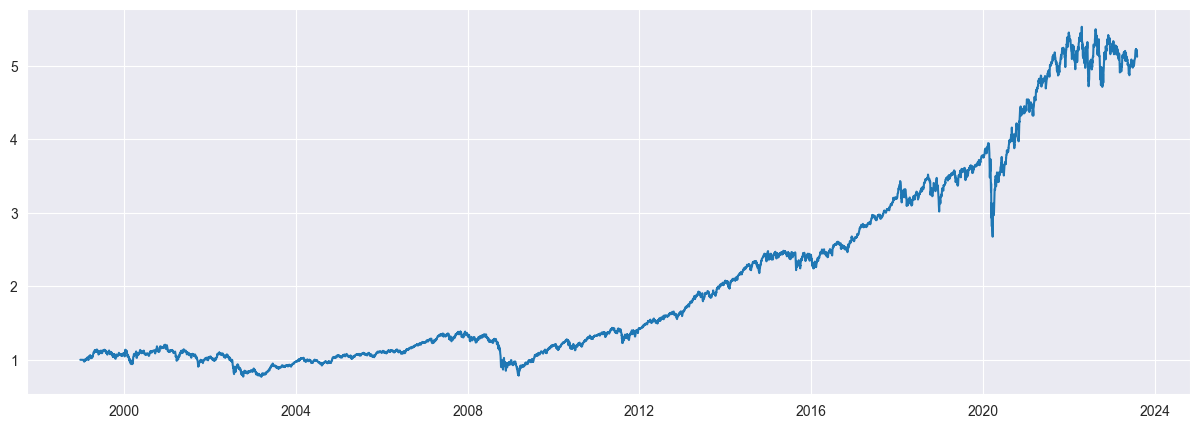

Sharpe: 0.498
Individual asset returns to strategy (highest to lowest): 
XLV    0.397596
XLK    0.388209
XLU    0.324549
XLP    0.311261
XLF    0.259841
XLY    0.167414
XLE    0.061565
XLB    0.056000
XLI   -0.023452
dtype: float64


In [45]:
def backtest(dataframe, highest_sharpe):
    lookback = lookbacks[highest_sharpe]

    print('Best Lookback Window', lookback)

    signal = dataframe.rolling(lookback).std().values * -1

    weighted_signal = getSignal(dataframe, signal, cross_sectional=True, long_only=True)
    # weighted_signal *= -1

    print('Current weights as a % of portfolio:')
    print(weighted_signal.iloc[-1] * 100)

    portfolio_returns = (weighted_signal.shift() * dataframe).sum(axis=1)
    cumulative_returns = (portfolio_returns + 1).cumprod()
    plt.plot(cumulative_returns)

    plt.show()

    print('Sharpe:', round((portfolio_returns.mean() / portfolio_returns.std() * np.sqrt(252)), 3))

    column_returns = (weighted_signal.shift() * dataframe).sum()
    print('Individual asset returns to strategy (highest to lowest): ')
    print(column_returns.sort_values(ascending=False))

backtest(normalizedDataframe, highest_sharpe)

# Notes

The best lookback window for this long-only cross-sectional low-volatility strategy is 17 days, and the highest returning sector is healthcare. While this strat does have amazing performance from inception to 2009, afterwards it just trades sideways.